# ConvFinQA LLM-Based Prototype

Each sample in the ConvFinQA dataset contains some textual and tabular financial information (i.e. context), some questions about the provided information, and expected answers to those questions. The goal is to use Large Language Models to answer the questions based on the provided context. The questions can be split into two categories:

* **Retrieval**: The user asks for data that can be lifted directly from the context,
* **Operation**: The user asks for data that needs to be computed, combining data from the context in some way to produce a result.

A working system may have a user-friendly ChatGPT-style UI where a user can upload some context, and ask simple retrieval- or operation-style questions to get a final answer. This report describes an LLM-based prototype that would work behind-the-scenes in such a system, containing a description of the prototype, some performance metrics, and potential improvements.

## Prototype Description

The prototype is powered by `ConversationHandler` instances. This is a class that takes care of a single conversation with a user, by first loading in some initial messages to be sent to an LLM, taking in context from the user, and then passing user queries to the LLM (with some modifications) to produce answers to those queries.

The LLM used for testing in this prototype is [Mistral-Nemo-Instruct-2407](https://huggingface.co/mistralai/Mistral-Nemo-Instruct-2407), but this can easily be swapped for other text generation models. Mistral-Nemo-Instruct-2407 was chosen due to its **large context window** (128k tokens) and its training on **text generation** tasks, allowing it to process huge user context inputs and giving it the ability to generate contextually relevant responses across long conversations.

We can break down the steps that occur in an interaction:

1) First, a `ConversationHandler` instance would be created. This would require an LLM Inference Client for sending messages to and receiving messages from the LLM, and some user-provided context. Initially, a **few-shot prompt** ([Appendix A](#appendix-a)) is stored by the instance so that the LLM knows how to answer questions from the user effectively. After that, the user's context is appended to the prompt, as well as a reminder to the LLM to respond in a **specific format** ([Appendix B](#appendix-b)).
2) The user then starts asking questions about the context. Before sending the question to the LLM, the prompt is ammended with a reminder to the LLM to answer in the correct format, as well as the calculated answer to the previous question, if possible.
3) The ammended prompt is sent to the LLM and a response is received.
4) The `ConversationHandler` then attempts to parse the response:
    1) If the response is in **retrieval** format, it can be passed back to the user
    2) If the response is in **operation** format, the operation must be split into the **operation** and its two **arguments**. These will then be processed to produce a final answer that will be passed back to the user.
    3) If the response is not in a valid format, some consideration would have to be made as to how to deal with this in production. For the prototype, an error message detailing what went wrong is appended to an error log to understand what kinds of problems can occur that need to be fixed.
5) Repeat steps 2-4.

## Evaluation

The prototype was tested on the data in `train.json` from the [ConvFinQA Repository](https://github.com/czyssrs/ConvFinQA). Almost all questions can be answered in either a **retrieval** or a **single-operation** format (a very small minority of questions actually require multiple operations to occur in one go - these are left out of testing and are discussed in more detail in [Potential Improvements](#potential-improvements)). The prototype was tested on 3,014 entries, with each entry being composed of between 1-9 questions, giving a total of 11,018 individual questions.

To see the performance metrics, of the prototype, we first need to do the necessary imports and load in the data.

### Imports

In [2]:
import sys
import os

src_path = "../src"
sys.path.insert(0, src_path)

hf_token = os.environ["HUGGINGFACE_TOKEN"]

In [3]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import asdict

from data import load_data
from analyser import Analyser

In [4]:
type1_entries = load_data(f"../data/processed/train1.json")
type2_entries = load_data(f"../data/processed/train2.json")
entries = type1_entries | type2_entries
a = Analyser(entries, "../data/runs/run2_5.pickle")

We use an `Analyser` instance to compare the expected results in `entries` to the generated results in the pickle file. This will produce `Accuracy` objects with three attributes:

* `score`: Total number of correct answers,
* `total`: Total number of questions,
* `accuracy`: `score` / `total`.

### Computational vs Operation vs Retrieval Accuracy

We can get an initial idea of the prototype's performance by simply measuring the accuracy of the calculated answers over all questions. This is calculated by comparing just the final numerical answers between those in the dataset and those produced by the prototype. We call this **computational accuracy**. Another way we can measure performance is with **operation accuracy**, which removes the dependency on earlier answers being correct by instead comparing the generated operation. For example:

In [10]:
a.compare([0, 4, 6])

Entry 0
----------------------------------------
Computations
Expected : [206588.0, 181001.0, 25587.0, 0.14136]
Generated: [206588.0, 181001.0, 25587.0, 0.1413638598681775]
Computational Accuracy: Accuracy(score=4, total=4, accuracy=1.0)
----------------------------------------
Retrievals and Operations
Expected : ['206588', '181001', 'subtract(206588.0, 181001.0)', 'divide(ANS2, 181001.0)']
Generated: ['206588', '181001', 'subtract(ANS0, ANS1)', 'divide(ANS2, ANS1)']
Retrieval Accuracy: Accuracy(score=2, total=2, accuracy=1.0)
Operation Accuracy: Accuracy(score=2, total=2, accuracy=1.0)
----------------------------------------

Entry 4
----------------------------------------
Computations
Expected : [-8.94, -0.0894, -24.05, -0.2405, 2.11, 0.0211, -0.2616]
Generated: [-8.939999999999998, -0.08939999999999998, -13.539999999999992, -0.1353999999999999, 2.1099999999999994, 0.021099999999999994, -0.15649999999999992]
Computational Accuracy: Accuracy(score=4, total=7, accuracy=0.57142857142

Above shows a comparison for some entries in a dataset between their expected and their generated computed answers and retrievals/operations for each question. For example, for entry 0, the expected computed answer to the first question was 206588.0, and the generated answer was also 206588.0, making this a correct result. We can see all numerical values match for entry 0, giving it **100% computational accuracy**. We also notice that the operations match too (after substituting in the correct values for ANS0, ANS1, and ANS2), giving it **100% operation accuracy**.

Entry 4 on the other hand has three mismatches between its expected and generated computed answers, giving it an **computational accuracy of 4/7**. However, two of those mistakes came from using an incorrect value from an earlier mistake in the conversation, but the actual operations given by the LLM were correct; the **operation accuracy here is 6/7**.

Operational accuracy is only calculated over **operation** questions, to target the LLM's ability to correctly generate an operation. Therefore, for entry 6, we say it has a **operation accuracy of 1/2**, as two of the expected results are operations (`subtract(3.7, 3.2)` and `divide(ANS0, 3.2)`), and only one of those is correct. We can also measure **retrieval** accuracy, which is the LLM's ability to correctly retrieve a value from the text. Entry 6 has a **retrieval accuracy of 0/1**, as it expects 3.2 to be retrieved for the second question, but the LLM fails to retrieve the correct value, instead generating an operation `add(ANS0, 3200)`.

We can now take a look at these measures over the full dataset:

In [24]:
a.computational_accuracy()

Accuracy(score=5978, total=10138, accuracy=0.589662655356086)

In [26]:
a.computational_accuracy_by_question_type()

{'retrieval': Accuracy(score=2493, total=3573, accuracy=0.6977329974811083),
 'operation': Accuracy(score=3485, total=6565, accuracy=0.5308453922315308)}

In [28]:
a.operation_accuracy()

Accuracy(score=4401, total=6565, accuracy=0.6703731911652704)

First we can see the **computational accuracy** over the full dataset sitting at **almost 60%**. We can break this down into **retrieval** and **operation** questions, and see **retrieval** questions seem to score fairly well, with the dataset hitting almost **70% retrieval accuracy**. Computational accuracy for **operation** questions seems fairly low at around **53%**, but when we remove the dependency on previous questions being correct, we see that the LLM is actually able to generate the correct operation (the **operation accuracy**) **67%** of the time, meaning 14% of the operation questions are incorrect simply because the wrong values were passed in.

These figures seem to suggest that the retrieval and the operation generation abilities of the LLM are fairly good, both coming close to 70%, but with still so many mistakes being made, these errors can easily get carried forward further down in the conversation.

### Type 1 vs Type 2 Entries

The authors of the ConvFinQA dataset describe two different types of conversations:

* **Type 1**: These are simple conversations formed by the decomposition of a single multi-hop question
* **Type 2**: These are hybrid conversations formed by the decomposition and integration of two multi-hop questions

We can compare the accuracy of the two conversation types:

In [10]:
a.answer_accuracy(type1_entries.keys())

Accuracy(score=4010, total=6600, accuracy=0.6075757575757575)

In [12]:
a.answer_accuracy(type2_entries.keys())

Accuracy(score=1809, total=3242, accuracy=0.5579888957433683)

In [16]:
a.program_accuracy(type1_entries.keys())

Accuracy(score=2907, total=4083, accuracy=0.7119764878765613)

In [18]:
a.program_accuracy(type2_entries.keys())

Accuracy(score=1372, total=2286, accuracy=0.600174978127734)

As we might expect, the simpler conversations seem to have higher accuracy. This is likely because Type 1 conversations involve a single, more straightforward multi-hop question, making it easier for the model to maintain context and focus. In contrast, Type 2 conversations involve integrating and synthesizing information from two separate multi-hop questions, which introduces additional complexity and potential for errors. The increased difficulty of managing and correctly integrating multiple pieces of information contributes to the lower accuracy observed in Type 2 conversations.

## Potential Improvements

The results show a good foundation upon which to build, but there is still some room to go to bring the answer accuracy close to 1. This section describes some of the potential improvements that could be made to the system, and how it might be brought into production.

## Appendix

### Appendix A: Few-Shot Prompt<a id='appendix-a'></a>

All conversations start with a few-shot prompt, which is an artificial conversation between a user and an assistant, with the LLM to take the role of the assistant during the main conversation:

---

**User**: You will be given a some context and then some questions that you will need to answer based on that context.

Each of your answers must start with a prefix ANS{i} = {your answer}, where {i} is replaced by the current question number (e.g. ANS0 for question 0, ANS1 for question 1, etc.), and {your answer} is filled with your answer.
Your answer will take one of two forms. You will need to understand whether the question is asking for retrieval of data from the context, or an operation to be performed on two retrieved or derived figures.
In the first case (retrieval), you must find the correct number that answers the question, and replace {your answer} with that exact number. If the value is a percentage, make sure to include the percentage sign at the end.
In the second case (operation), you must tell me the correct operation as well as the correct arguments for that operation. This must be written in the form "operation(arg1, arg2)". The following operations are permitted:
* add
* subtract
* multiply
* divide
* exp
* greater

Each argument must either be lifted from the text, in the same format as a you would provide for the retrieval case, or must be references to previous answers, written as ANS{i} where {i} is replaced with the index of the suitable answer.
For example, if you determine that the correct operation is to divide 3456 by ANS3, {your answer} will be replaced by "divide(3456, ANS3)".
I will provide an example conversation.

**Assistant**: Understood. Please provide your example conversation.

**User**: This is the context:

<table class='wikitable'><tr><td>1</td><td>year</td><td>1993</td><td>1994</td><td>1995</td></tr><tr><td>2</td><td>revenue</td><td>£23,456</td><td>£43,219</td><td>£101,129</td></tr><tr><td>3</td><td>costs</td><td>£40,987</td><td>£47,231</td><td>£60,943</td></tr></table>

**Assistant**: Understood. What are your questions?

**User**: Q0: What was the revenue in 1993?

**Assistant**: ANS0 = 23456

**User**: Ok, so ANS0 = 23456. Now the next question:

Q1: What was the profit in 1993?


**Assistant**: ANS1 = subtract(ANS0, 40987)

**User**: Ok, so ANS1 = -17531. Now the next question:

Q2: What was the profit in 1994?

**Assistant**: ANS2 = subtract(43219, 47231)

**User**: Ok, so ANS2 = -4012. Now the next question:

Q3: What was the percentage change in profit between 1993 and 1994?

**Assistant**: ANS3 = divide(ANS2, ANS1)

**User**: Ok, so ANS3 = 0.22885174833. Now the next question:

Q4: What was the total revenue in 1993 and 1994?

**Assistant**: ANS4 = add(ANS0, 43219)

**User**: Good. Now we will do another example.

**Assistant**: Ok, what is the context?

**User**:

<table class='wikitable'><tr><td>customer</td><td>loan value (€)</td><td>interest rate (%)</td></tr><tr><td>1</td><td>2,014.45</td><td>9.27</td></tr><tr><td>2</td><td>23,015.13</td><td>9.11</td></tr><tr><td>3</td><td>1,095.42</td><td>8.77</td></tr><tr><td>4</td><td>13,732.56</td><td>10.10</td></tr></table>

**Assistant**: Understood. What are your questions?

**User**: Q0: What is the interest rate for customer 3's loan?

**Assistant**: ANS0 = 8.77%

**User**: Ok, so ANS0 = 0.0877. Now the next question:

Q1: What do I have to multiply customer 3's loan value by to get the loan's value in a year?

**Assistant**: ANS1 = add(1, ANS0)

**User**: Ok, so ANS1 = 1.0877. Now the next question:

Q2: How about after 7 years?

**Assistant**: ANS2 = exp(ANS1, 7)

**User**: Ok, so ANS2 = 1.80120813492. Now the next question:

Q3: So what is the loan's value after 7 years assuming no repayments?

**Assistant**: ANS3 = multiply(1095.42, ANS2)

**User**: Ok, so ANS3 = 1973.07941515. Now the next question:

Q4: What do I have to multiply customer 2's loan value by to get the loan's value in a year?

**Assistant**: ANS4 = add(1, 9.11%)

**User**: Ok, so ANS4 = 1.0911. Now the next question:

Q5: Is customer 3's loan after 7 years less than customer 2's loan after 1 year, assuming no repayments?

**Assistant**: ANS5 = greater(ANS4, ANS3)

**User**: Good. Now we will start the actual exercise.

**Assistant**: Great! What is the context?

---

The above conversation aims to show a use of all the possible operations, while repeating the response format that is expected to be used throughout the actual conversation.

The user's context is then provided in the following way:

---

**User**: {context}

**Assistant**: Understood. And what are your questions? I will make sure to only answer with a number, including a percentage sign \"%\" if I am asked for a percentage, or in the form operation(arg1, arg2).

---

From here, the main conversation begins.

### Appendix B: Response Format<a id='appendix-b'></a>

Each answer from the LLM is expected to be in the format "ANS{i} = {answer}" to ensure that the result can be parsed properly to produce a correct result. Including "ANS{i}", where "i" is the answer to the i-th question (0-indexed), allows the LLM to unambiguously reference previous answers in operation-style responses.

The {answer} section is either a retrieval- or a operation-style response:

* **Retrieval**: When a figure is to be retrieved from the text, it is simply copied over. During parsing, any whitespace on either side of the number and any spaces or commas within are removed. If a percentage sign is included at the end, the figure is divided by 100. The figure would then passed back as the answer to the question.
* **Operation**: This should be of the form operation(arg1, arg2). An operation can be one of:
    * add
    * subtract
    * multiply
    * divide
    * exp
    * greater

    The two arguments can either be a figure lifted from the text, to be processed in the same way as described above in **Retrieval**, or a reference to a previous answer in the form "ANS{i}", where "i" is the answer to the i-th question. The arguments first get converted to their numerical values and then the correct operation is performed on them. The result would then be passed back to the user.

# Rough

## Analysis

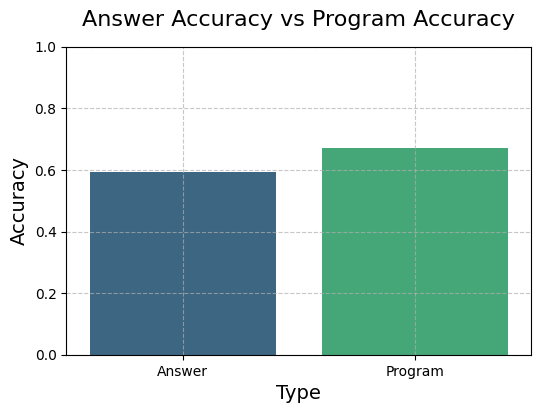

In [150]:
df = pd.DataFrame({
    "Type": ["Answer", "Program"],
    "Accuracy": [a.answer_accuracy().accuracy, a.program_accuracy().accuracy],
})

X = "Type"
Y = "Accuracy"
plt.figure(figsize=(6, 4))
bar_plot = sns.barplot(data=df, x=X, y=Y, hue=X, palette="viridis")
bar_plot.set_ylim(0, 1)
plt.title(f'Answer Accuracy vs Program Accuracy', fontsize=16, pad=15)
plt.xlabel(X, fontsize=14)
plt.ylabel(Y, fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

In [172]:
def acc_list_to_dict(lst):
    return {i: acc for i, acc in enumerate(lst)}

def to_df(acc_dict, separator, type_):
    return pd.DataFrame({
        separator: list(acc_dict.keys()),
        'Accuracy': [acc.accuracy for acc in acc_dict.values()],
        'Total': [acc.total for acc in acc_dict.values()],
        'Type': type_
    })

def plot(answer_df, program_df, separator):
    Y = "Accuracy"
    HUE = "Type"
    TOTAL = "Total"
    
    df = pd.concat([answer_df, program_df])

    plt.figure(figsize=(12, 8))
    bar_plot = sns.barplot(data=df, x=separator, y=Y, hue=HUE, palette="viridis")

    bar_plot.set_ylim(0, 1)
    
    plt.title(f'Comparison of Accuracy Scores by {separator}', fontsize=16, pad=30)
    plt.xlabel(separator, fontsize=14)
    plt.ylabel(Y, fontsize=14)
    plt.legend(title_fontsize='13', fontsize='12')
    plt.grid(True, linestyle='--', alpha=0.7)

    bars = [p for p in bar_plot.patches if p.get_width() > 0]
    n = len(answer_df)

    for i, x in enumerate([p.get_x() + p.get_width() / 2 for p in bars]):
        y = bar_plot.get_ylim()[1]
        if i < len(bars)//2:
            sample_count = answer_df[TOTAL]
        else:
            sample_count = program_df[TOTAL]
            y *= 1.02
        bar_plot.text(x, y, f'n={sample_count[i % n]}', ha='center', va='bottom', fontsize=10, color='black')
    plt.show()

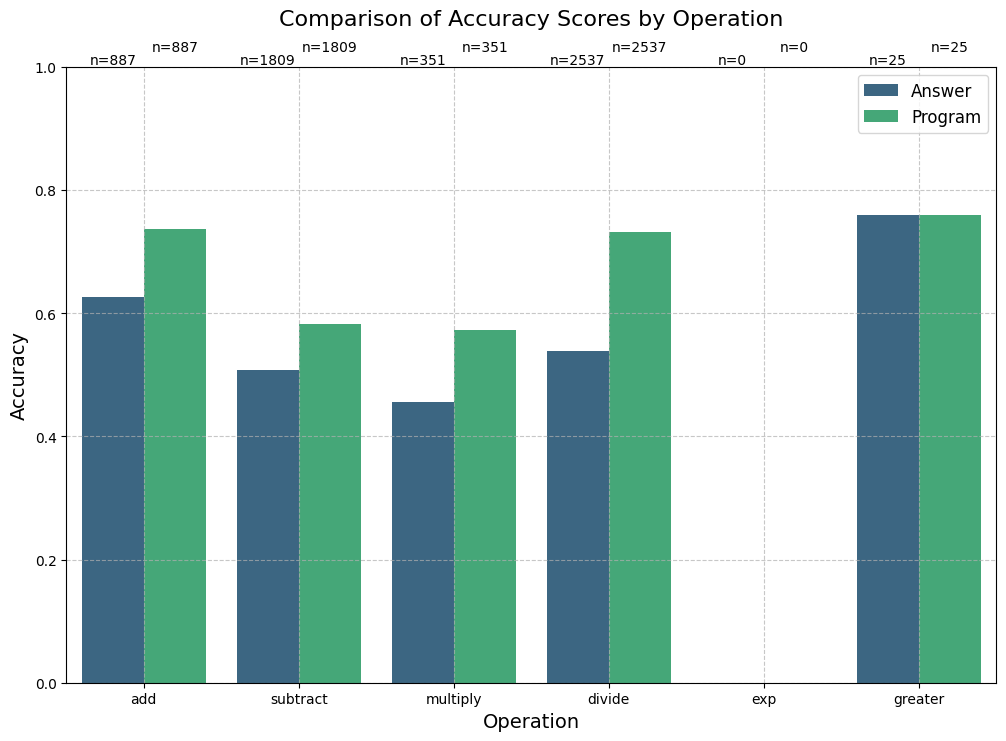

In [174]:
separator = "Operation"
aa_op = a.answer_accuracy_by_operation()
pa_op = a.program_accuracy_by_operation()
aa_op_df = to_df(aa_op, separator, "Answer")
pa_op_df = to_df(pa_op, separator, "Program")
plot(aa_op_df, pa_op_df, separator)

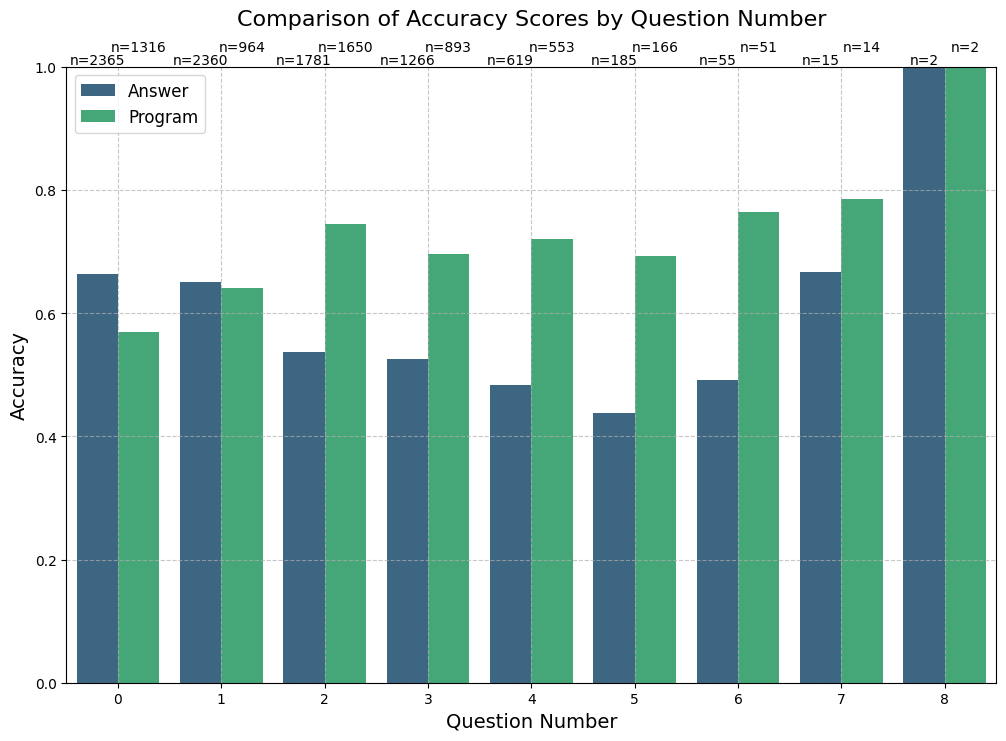

In [176]:
separator = "Question Number"
aa_qn = a.answer_accuracy_by_question_number()
pa_qn = a.program_accuracy_by_question_number()
aa_qn_df = to_df(acc_list_to_dict(aa_qn), separator, "Answer")
pa_qn_df = to_df(acc_list_to_dict(pa_qn), separator, "Program")
plot(aa_qn_df, pa_qn_df, separator)

In [152]:
a.answer_accuracy()

Accuracy(score=5477, total=9244, accuracy=0.5924924275205539)

In [154]:
a.answer_accuracy_by_operation()

{'add': Accuracy(score=583, total=940, accuracy=0.6202127659574468),
 'subtract': Accuracy(score=985, total=1936, accuracy=0.5087809917355371),
 'multiply': Accuracy(score=172, total=383, accuracy=0.4490861618798956),
 'divide': Accuracy(score=1448, total=2707, accuracy=0.5349094939046916),
 'exp': Accuracy(score=0, total=0, accuracy=0),
 'greater': Accuracy(score=22, total=29, accuracy=0.7586206896551724)}

In [156]:
a.answer_accuracy_by_question_number()

[Accuracy(score=1667, total=2529, accuracy=0.6591538157374456),
 Accuracy(score=1634, total=2524, accuracy=0.6473851030110935),
 Accuracy(score=1018, total=1902, accuracy=0.5352260778128286),
 Accuracy(score=713, total=1361, accuracy=0.523879500367377),
 Accuracy(score=317, total=658, accuracy=0.4817629179331307),
 Accuracy(score=87, total=196, accuracy=0.44387755102040816),
 Accuracy(score=29, total=57, accuracy=0.5087719298245614),
 Accuracy(score=10, total=15, accuracy=0.6666666666666666),
 Accuracy(score=2, total=2, accuracy=1.0)]

In [158]:
a.answer_accuracy_by_question_type()

{'retrieval': Accuracy(score=2267, total=3249, accuracy=0.6977531548168667),
 'program': Accuracy(score=3210, total=5995, accuracy=0.5354462051709759)}

In [160]:
a.program_accuracy()

Accuracy(score=4033, total=5995, accuracy=0.6727272727272727)

In [162]:
a.program_accuracy_by_operation()

{'add': Accuracy(score=688, total=940, accuracy=0.7319148936170212),
 'subtract': Accuracy(score=1128, total=1936, accuracy=0.5826446280991735),
 'multiply': Accuracy(score=223, total=383, accuracy=0.5822454308093995),
 'divide': Accuracy(score=1972, total=2707, accuracy=0.7284817140746214),
 'exp': Accuracy(score=0, total=0, accuracy=0),
 'greater': Accuracy(score=22, total=29, accuracy=0.7586206896551724)}

In [164]:
a.program_accuracy_by_question_number()

[Accuracy(score=796, total=1408, accuracy=0.5653409090909091),
 Accuracy(score=659, total=1035, accuracy=0.6367149758454106),
 Accuracy(score=1306, total=1759, accuracy=0.7424673109721432),
 Accuracy(score=671, total=961, accuracy=0.6982310093652445),
 Accuracy(score=424, total=587, accuracy=0.7223168654173765),
 Accuracy(score=123, total=176, accuracy=0.6988636363636364),
 Accuracy(score=41, total=53, accuracy=0.7735849056603774),
 Accuracy(score=11, total=14, accuracy=0.7857142857142857),
 Accuracy(score=2, total=2, accuracy=1.0)]

# Compare Run 1 vs Run 2

In [22]:
a1 = Analyser(entries, "../data/runs/run1.pickle")
a2 = Analyser(entries, "../data/runs/run2.pickle")

In [24]:
n = len(a1.conversations)
indices = sorted(list(a1.conversations))[:n]

In [26]:
a1.answer_accuracy()

Accuracy(score=743, total=1449, accuracy=0.5127674258109041)

In [28]:
a2.answer_accuracy(indices)

Accuracy(score=811, total=1449, accuracy=0.559696342305038)

In [30]:
a1.answer_accuracy_by_operation()

{'add': Accuracy(score=80, total=140, accuracy=0.5714285714285714),
 'subtract': Accuracy(score=130, total=306, accuracy=0.42483660130718953),
 'multiply': Accuracy(score=22, total=62, accuracy=0.3548387096774194),
 'divide': Accuracy(score=171, total=413, accuracy=0.41404358353510895),
 'exp': Accuracy(score=0, total=0, accuracy=0),
 'greater': Accuracy(score=2, total=3, accuracy=0.6666666666666666)}

In [32]:
a2.answer_accuracy_by_operation(indices)

{'add': Accuracy(score=76, total=140, accuracy=0.5428571428571428),
 'subtract': Accuracy(score=147, total=306, accuracy=0.4803921568627451),
 'multiply': Accuracy(score=24, total=62, accuracy=0.3870967741935484),
 'divide': Accuracy(score=201, total=413, accuracy=0.48668280871670705),
 'exp': Accuracy(score=0, total=0, accuracy=0),
 'greater': Accuracy(score=3, total=3, accuracy=1.0)}

In [34]:
a1.answer_accuracy_by_question_number()

[Accuracy(score=236, total=396, accuracy=0.5959595959595959),
 Accuracy(score=217, total=394, accuracy=0.550761421319797),
 Accuracy(score=134, total=298, accuracy=0.44966442953020136),
 Accuracy(score=85, total=208, accuracy=0.40865384615384615),
 Accuracy(score=45, total=98, accuracy=0.45918367346938777),
 Accuracy(score=20, total=41, accuracy=0.4878048780487805),
 Accuracy(score=5, total=11, accuracy=0.45454545454545453),
 Accuracy(score=1, total=3, accuracy=0.3333333333333333)]

In [36]:
a2.answer_accuracy_by_question_number(indices)

[Accuracy(score=253, total=396, accuracy=0.6388888888888888),
 Accuracy(score=249, total=394, accuracy=0.631979695431472),
 Accuracy(score=138, total=298, accuracy=0.46308724832214765),
 Accuracy(score=104, total=208, accuracy=0.5),
 Accuracy(score=45, total=98, accuracy=0.45918367346938777),
 Accuracy(score=15, total=41, accuracy=0.36585365853658536),
 Accuracy(score=5, total=11, accuracy=0.45454545454545453),
 Accuracy(score=2, total=3, accuracy=0.6666666666666666)]

In [38]:
a1.answer_accuracy_by_question_type()

{'retrieval': Accuracy(score=338, total=525, accuracy=0.6438095238095238),
 'program': Accuracy(score=405, total=924, accuracy=0.4383116883116883)}

In [40]:
a2.answer_accuracy_by_question_type(indices)

{'retrieval': Accuracy(score=360, total=525, accuracy=0.6857142857142857),
 'program': Accuracy(score=451, total=924, accuracy=0.4880952380952381)}

In [42]:
a1.program_accuracy()

Accuracy(score=547, total=924, accuracy=0.591991341991342)

In [44]:
a2.program_accuracy(indices)

Accuracy(score=599, total=924, accuracy=0.6482683982683982)

In [46]:
a1.program_accuracy_by_operation()

{'add': Accuracy(score=101, total=140, accuracy=0.7214285714285714),
 'subtract': Accuracy(score=150, total=306, accuracy=0.49019607843137253),
 'multiply': Accuracy(score=27, total=62, accuracy=0.43548387096774194),
 'divide': Accuracy(score=268, total=413, accuracy=0.648910411622276),
 'exp': Accuracy(score=0, total=0, accuracy=0),
 'greater': Accuracy(score=1, total=3, accuracy=0.3333333333333333)}

In [48]:
a2.program_accuracy_by_operation(indices)

{'add': Accuracy(score=103, total=140, accuracy=0.7357142857142858),
 'subtract': Accuracy(score=169, total=306, accuracy=0.5522875816993464),
 'multiply': Accuracy(score=31, total=62, accuracy=0.5),
 'divide': Accuracy(score=295, total=413, accuracy=0.7142857142857143),
 'exp': Accuracy(score=0, total=0, accuracy=0),
 'greater': Accuracy(score=1, total=3, accuracy=0.3333333333333333)}

In [50]:
a1.program_accuracy_by_question_number()

[Accuracy(score=102, total=211, accuracy=0.4834123222748815),
 Accuracy(score=82, total=155, accuracy=0.5290322580645161),
 Accuracy(score=182, total=279, accuracy=0.6523297491039427),
 Accuracy(score=90, total=149, accuracy=0.6040268456375839),
 Accuracy(score=60, total=80, accuracy=0.75),
 Accuracy(score=24, total=38, accuracy=0.631578947368421),
 Accuracy(score=5, total=9, accuracy=0.5555555555555556),
 Accuracy(score=2, total=3, accuracy=0.6666666666666666)]

In [52]:
a2.program_accuracy_by_question_number(indices)

[Accuracy(score=117, total=211, accuracy=0.5545023696682464),
 Accuracy(score=89, total=155, accuracy=0.5741935483870968),
 Accuracy(score=196, total=279, accuracy=0.7025089605734767),
 Accuracy(score=103, total=149, accuracy=0.6912751677852349),
 Accuracy(score=59, total=80, accuracy=0.7375),
 Accuracy(score=26, total=38, accuracy=0.6842105263157895),
 Accuracy(score=7, total=9, accuracy=0.7777777777777778),
 Accuracy(score=2, total=3, accuracy=0.6666666666666666)]